In [38]:
import re
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfTransformer

In [51]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import html
import gensim
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [52]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [53]:
#DATA

df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/test.csv")
df_labels = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

In [54]:
# Shuffling data
df = df.sample(frac=1)
# Dropping duplicates
df = df.drop_duplicates(subset=['text'])

In [55]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
#removes HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
#removes all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
#removes URLs
    clean = re.sub('\W+',' ', clean)                   
#replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [56]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [57]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

22352    light compromise health mercola light affect h...
18400    pathologization dissent photo jamelle bouie ac...
17860    today equate steve bannon islamic state leader...
7638     ram select jar goff pick draft york time chica...
13441    influential french author alain soral pilled a...
                               ...                        
14892    republican convention night miss york time eye...
19458    fitton obama scandal continue judicial watch f...
9708     comment bioethicists conscientious objector eu...
9026     вместо хлеба патроны танки новое восточное обо...
5144     trump get dump instagram supermodel gisele bün...
Name: clean_joined, Length: 25433, dtype: object


In [78]:
#COUNT VECTORIZER - counts  the occurrence of each word for every single text in order to create a vector

from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

#vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer = CountVectorizer()
vectorizer.fit(df['clean_joined'])
# Transforming training and validation data using count vectorizer object
X_train_count = vectorizer.transform(X_train.values)
X_test_count = vectorizer.transform(X_test.values)


Model accuracy is :  0.8268134460389227
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      2558
           1       0.91      0.72      0.81      2529

    accuracy                           0.83      5087
   macro avg       0.84      0.83      0.82      5087
weighted avg       0.84      0.83      0.82      5087



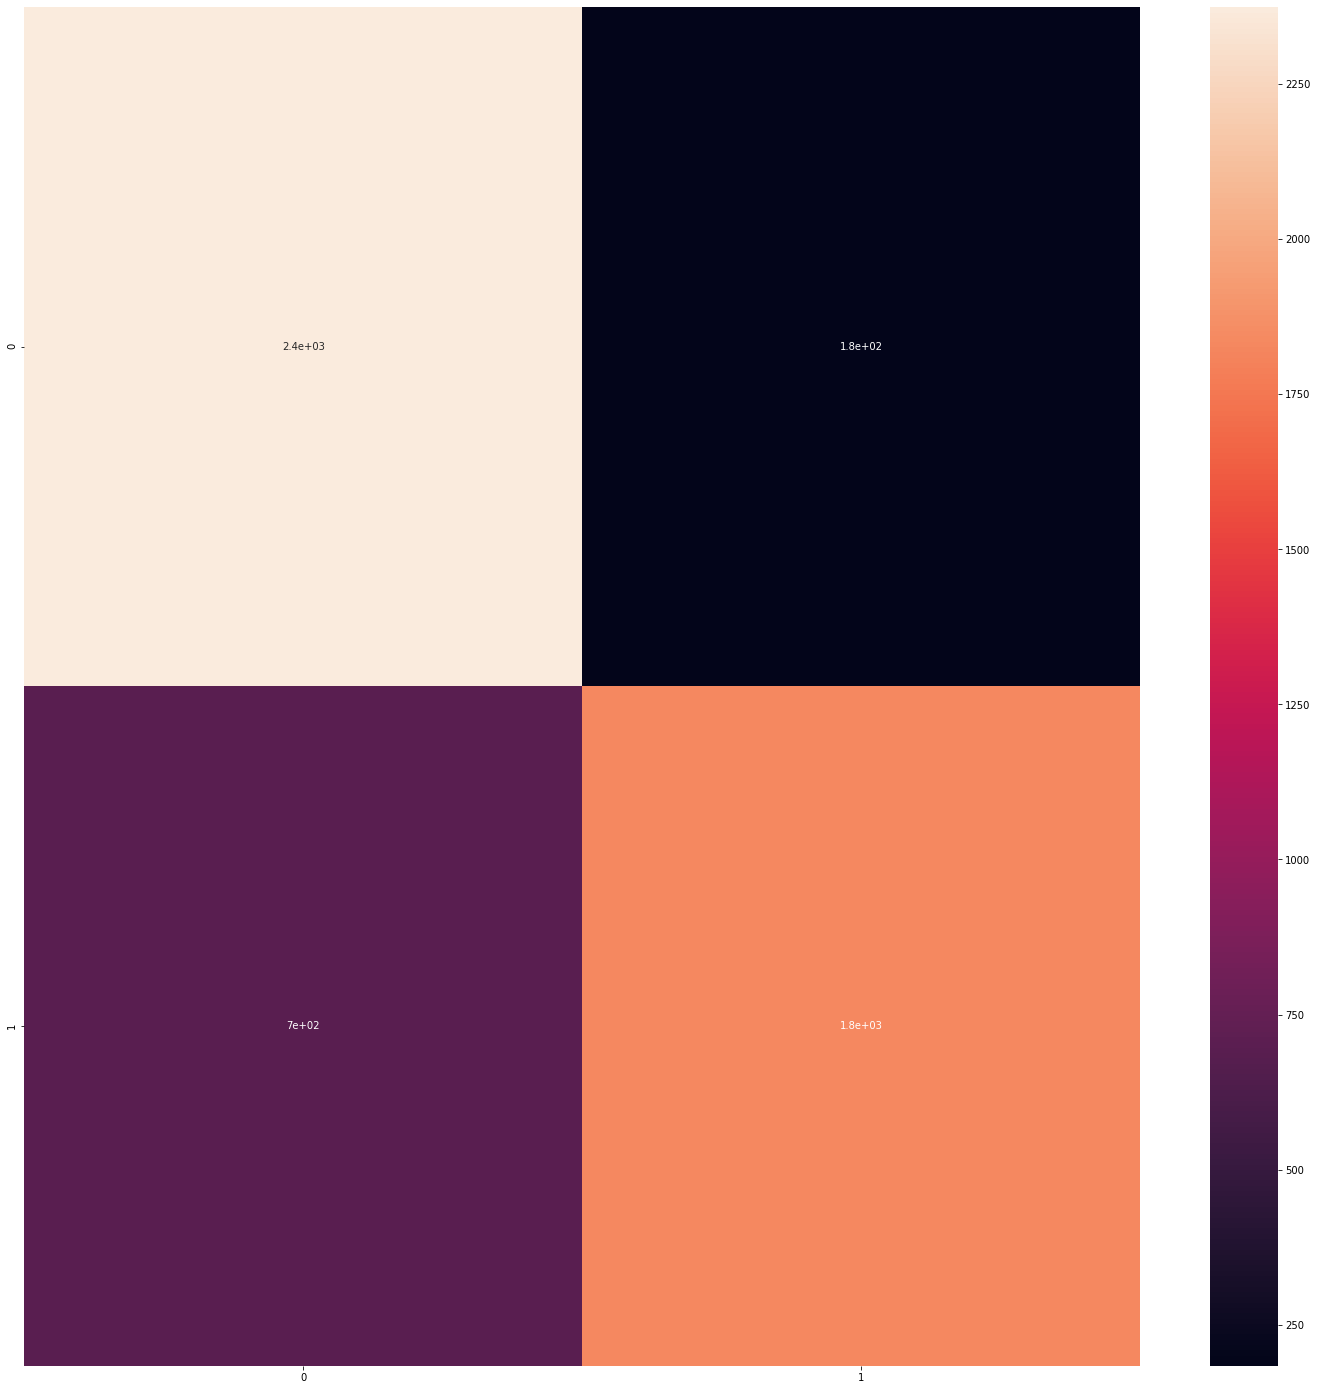

In [82]:
# NAIVE BAYES CLASSIFIER

from sklearn import naive_bayes

model = naive_bayes.MultinomialNB()
model.fit(X_train_count, y_train)

## Plot confusion matrix

pred = model.predict(X_test_count)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

In [63]:
# Frequency of the words in a vectorizer
sum_words = X_train_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [64]:
words_freq

[('say', 91858),
 ('trump', 59417),
 ('state', 39425),
 ('time', 37469),
 ('people', 36491),
 ('year', 33646),
 ('clinton', 28259),
 ('like', 27280),
 ('president', 26017),
 ('american', 22657),
 ('know', 20967),
 ('go', 20728),
 ('work', 19635),
 ('come', 19445),
 ('government', 17933),
 ('think', 17713),
 ('country', 17534),
 ('report', 16464),
 ('world', 16016),
 ('want', 15906),
 ('election', 15687),
 ('tell', 15625),
 ('take', 15346),
 ('news', 15248),
 ('right', 15239),
 ('unite', 15211),
 ('hillary', 15166),
 ('york', 14994),
 ('include', 14584),
 ('obama', 14570),
 ('house', 14151),
 ('campaign', 14054),
 ('good', 13981),
 ('vote', 13832),
 ('call', 13256),
 ('leave', 12895),
 ('white', 12524),
 ('republican', 12520),
 ('woman', 12507),
 ('official', 12409),
 ('group', 12353),
 ('unite state', 12326),
 ('need', 12262),
 ('medium', 12062),
 ('live', 11850),
 ('look', 11627),
 ('long', 11568),
 ('company', 11361),
 ('political', 11323),
 ('late', 11281),
 ('million', 11228),
 ('s

In [65]:
neg_class_prob_sorted = model.feature_log_prob_[0, :].argsort()[::-1]

print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:200]))

['say' 'trump' 'state' 'president' 'time' 'people' 'year' 'like' 'clinton'
 'american' 'republican' 'york' 'breitbart' 'house' 'unite' 'go' 'obama'
 'news' 'country' 'work' 'report' 'company' 'police' 'official'
 'government' 'think' 'know' 'woman' 'come' 'campaign' 'white'
 'unite state' 'want' 'city' 'percent' 'tell' 'include' 'vote' 'party'
 'take' 'group' 'attack' 'twitter' 'week' 'court' 'plan' 'york time'
 'right' 'call' 'administration' 'good' 'million' 'national' 'election'
 'leave' 'donald' 'political' 'world' 'late' 'live' 'donald trump'
 'medium' 'security' 'write' 'policy' 'school' 'family' 'democrat'
 'follow' 'change' 'case' 'look' 'help' 'russia' 'member' 'public'
 'support' 'accord' 'month' 'need' 'federal' 'add' 'health' 'long'
 'officer' 'child' 'russian' 'department' 'white house' 'team' 'issue'
 'thing' 'leader' 'force' 'executive' 'home' 'kill' 'game' 'order' 'ask'
 'office' 'play' 'question' 'statement' 'immigration' 'china' 'washington'
 'begin' 'meet' 'student' 

In [66]:
pos_class_prob_sorted = model.feature_log_prob_[1, :].argsort()[::-1]
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:200]))

['trump' 'clinton' 'hillary' 'say' 'election' 'state' 'people' 'vote'
 'email' 'hillary clinton' 'russia' 'american' 'year' 'president' 'time'
 'world' 'report' 'obama' 'like' 'know' 'campaign' 'government' 'medium'
 'donald' 'russian' 'news' 'go' 'donald trump' 'right' 'october' 'video'
 'think' 'country' 'post' 'come' 'america' 'tell' 'work' 'want' 'woman'
 'november' 'voter' 'investigation' 'comey' 'need' 'support' 'police'
 'force' 'syria' 'white' 'military' 'republican' 'good' 'political'
 'comment' 'share' 'thing' 'live' 'party' 'take' 'leave' 'power' 'attack'
 'look' 'change' 'source' 'house' 'million' 'poll' 'presidential' 'black'
 'unite' 'follow' 'article' 'call' 'candidate' 'twitter' 'accord' 'child'
 'today' 'group' 'wikileaks' 'public' 'point' 'information' 'policy'
 'fact' 'help' 'claim' 'long' 'believe' 'write' 'include' 'life' 'happen'
 'democrat' 'story' 'plan' 'case' 'mean' 'give' 'continue' 'great'
 'national' 'high' 'official' 'unite state' 'putin' 'facebook' 'contr